In [7]:
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad as integral
from collections import OrderedDict
from scipy.stats import kstest
from scipy import stats

%matplotlib nbagg

In [2]:
BDIR=f"./"

In [3]:
FIGDIR=f"{BDIR}/figures/"

## Useful routines

In [4]:
def multiNorm(x,params,xmin=None,xmax=None):
    """
    x: Value
    params: weigths, locs, scales
    args:
        N: normalization constant
        xmin, xmax: Truncation constants
    """
    N=np.int(len(params)/3)
    weights=params[:N]
    Nint=sum(weights)    
    locs=params[N:2*N]
    scales=params[2*N:]
    y=0
    for n in range(N):
        y+=weights[n]*stats.norm.pdf(x,loc=locs[n],scale=scales[n])
    return y/Nint

def multiNormParams(weights=[1.0],locs=[0.0],scales=[1.0]):
    N=len(weights)
    params=list(weights)+list(locs)+list(scales)
    bounds=(WBOUNDS,)*N+(LBOUNDS,)*N+(SBOUNDS,)*N
    return N,params,bounds

def multiNormCDF(x,params,xmin=None,xmax=None):
    """
    x: Value
    params: weigths, locs, scales
    args:
        N: normalization constant
        xmin, xmax: Truncation constants
    """
    N=np.int(len(params)/3)
    weights=params[:N]
    Nint=sum(weights)
    locs=params[N:2*N]
    scales=params[2*N:]
    y=0
    for n in range(N):
        y+=weights[n]*stats.norm.cdf(x,loc=locs[n],scale=scales[n])
    return y/Nint

def multiNormExt(params,nsigma=5.0):
    N=np.int(len(params)/3)
    locs=np.array(params[N:2*N])
    scales=np.array(params[2*N:])
    
    #Extremes in x
    xmins=locs-nsigma*scales
    xmaxs=locs+nsigma*scales
    
    #Extremes in y
    maxval=-1e100
    for loc in locs:
        val=multiNorm(loc,params)
        if val>maxval:maxval=val
    
    return xmins.min(),xmaxs.max(),maxval

def rejectionGenerate(N,xmin,xmax,pmax,pdf,params,**args):
    xs=np.zeros(N)
    for n in range(N):
        p=0;u=1
        while u>p:
            x=np.random.uniform(xmin,xmax)
            p=pdf(x,params,**args)
            u=np.random.uniform(0,pmax)
        xs[n]=x
    return xs

def Likelihood(params,data,pdf,**args):
    logL=0
    for point in data:
        p=pdf(point,params,**args)
        logp=np.log10(p)
        logL-=logp
    return logL

#Bounds
WBOUNDS=(0,10)
LBOUNDS=(-10,10)
SBOUNDS=(1e-1,10)

## Test distribution

In [8]:
N,params,bounds=multiNormParams(weights=[1.0,2.0],locs=[-1.0,2.0],scales=[1,1])
print(f"N = {N}, params = {params}, bounds = {bounds}")
xmin,xmax,pmax=multiNormExt(params) 
print(f"Extrema: x = ({xmin},{xmax}), pmax = {pmax}")

N = 2, params = [1.0, 2.0, -1.0, 2.0, 1, 1], bounds = ((0, 10), (0, 10), (-10, 10), (-10, 10), (0.1, 10), (0.1, 10))
Extrema: x = (-6.0,7.0), pmax = 0.2674388030716011


<IPython.core.display.Javascript object>


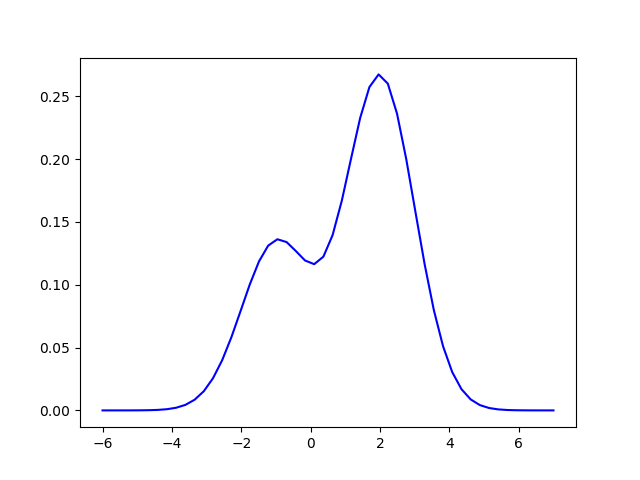

In [9]:
fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax)
ax.plot(xt,multiNorm(xt,params),'b-')

fig.savefig(f"{FIGDIR}/plot_multinorm.png")

In [10]:
#%timeit -n 100 multiNorm(0,params)

In [11]:
N=5000
xmin,xmax,pmax=multiNormExt(params)
x=rejectionGenerate(N,xmin,xmax,pmax,multiNorm,params)

xt=np.linspace(xmin,xmax,100)
yt=multiNorm(xt,params)
y=np.random.uniform(0,pmax,N)

<IPython.core.display.Javascript object>


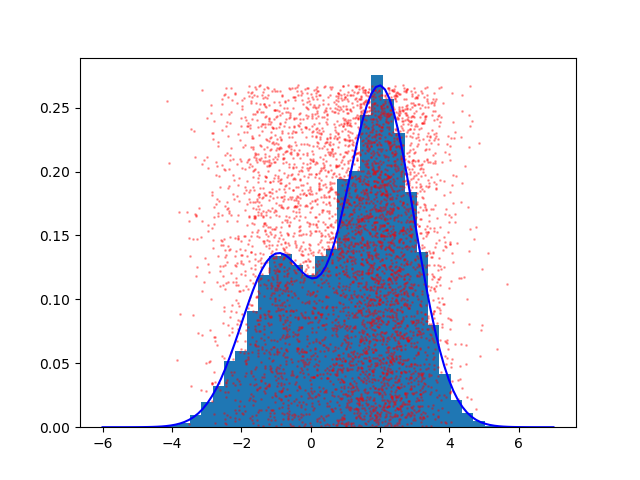

In [12]:
fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'ro',ms=1,alpha=0.3)
ax.hist(x,30,normed=True)
ax.plot(xt,yt,'b-')

fig.savefig(f"{FIGDIR}/hist_multinorm.png")

In [13]:
ks,p=kstest(x,multiNormCDF,args=(params,))
print(f"p-value = {p}")

p-value = 0.09310015531772743


## Test likelihood

In [14]:
N=100
x=rejectionGenerate(N,xmin,xmax,pmax,multiNorm,params)

In [15]:
Likelihood(params,x,multiNorm)

82.83684175612387

In [16]:
print(f"Input parameters: {params}")
margs=dict(method='SLSQP',bounds=bounds)
solution=minimize(Likelihood,params,args=(x,multiNorm),**margs)
solution

Input parameters: [1.0, 2.0, -1.0, 2.0, 1, 1]


     fun: 82.57756939409809
     jac: array([-1.31607056e-04,  5.24520874e-05,  1.14440918e-04, -1.23977661e-05,
       -3.14712524e-05, -8.29696655e-05])
 message: 'Optimization terminated successfully.'
    nfev: 87
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.86701727,  2.04688084, -1.24271264,  1.87441714,  0.78117099,
        1.09502456])

In [17]:
fparams=solution.x
ks,p=kstest(x,multiNormCDF,args=(fparams,))
print(f"p-value = {p}")

p-value = 0.871745506230134


<IPython.core.display.Javascript object>


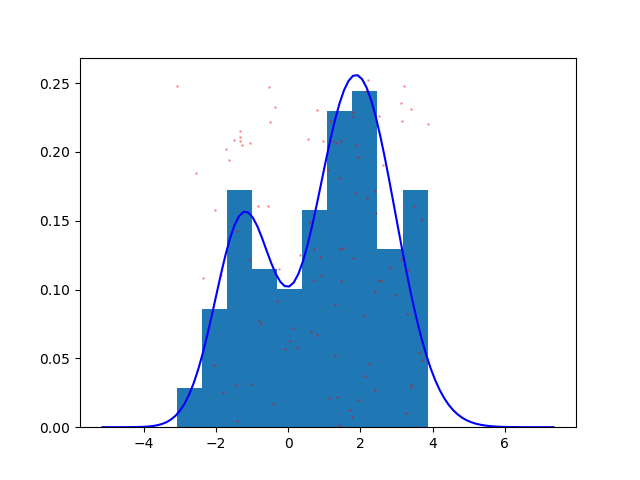

In [18]:
xmin,xmax,pmax=multiNormExt(fparams)
xt=np.linspace(xmin,xmax,100)
yt=multiNorm(xt,fparams)
y=np.random.uniform(0,pmax,N)

fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'ro',ms=1,alpha=0.3)
ax.hist(x,normed=True)
ax.plot(xt,yt,'b-')

fig.savefig(f"{FIGDIR}/fit_multinorm.png")

## Test fit using a different distribution

In [19]:
def trianglePDF(x,params):
    a=params[0]
    b=params[1]
    m=(a+b)/2
    if x<=a or x>=b:
        return 0
    Nint=(b-a)/2
    if x<=m:
        y=(x-a)/(m-a)
    else:
        y=1-(x-m)/(b-m)
    return y/Nint

In [20]:
params=[0.0,1.0]
xmin,xmax=params
pmax=2/(xmax-xmin)

<IPython.core.display.Javascript object>


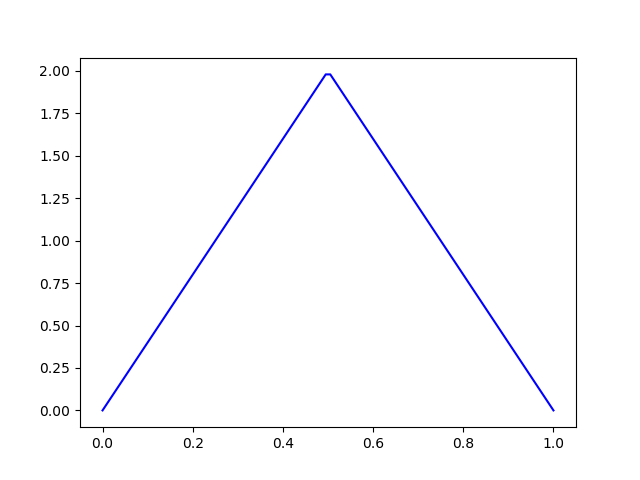

In [21]:
fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax,100)
ax.plot(xt,[trianglePDF(x,params) for x in xt],'b-')

fig.savefig(f"{FIGDIR}/plot_triangle.png")

In [22]:
#integral(trianglePDF,xmin,xmax,args=(params,))
integral(trianglePDF,-np.inf,np.inf,args=(params,))

(0.9999999999999984, 2.1918477033366912e-09)

In [23]:
Npoints=1000
x=rejectionGenerate(Npoints,xmin,xmax,pmax,trianglePDF,params)
y=np.random.uniform(0,pmax,Npoints)

<IPython.core.display.Javascript object>


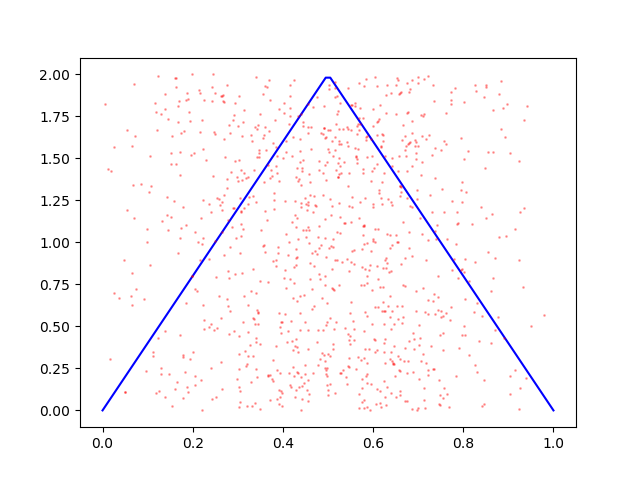

In [24]:
fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax,100)
ax.plot(xt,[trianglePDF(x,params) for x in xt],'b-')
ax.plot(x,y,'ro',ms=1,alpha=0.3)

fig.savefig(f"{FIGDIR}/plot_triangle.png")

### Fit

In [25]:
N,gparams,bounds=multiNormParams(weights=[1.0],locs=[1.0],scales=[1.0])
margs=dict(method='SLSQP',bounds=bounds)
solution=minimize(Likelihood,gparams,args=(x,multiNorm),**margs)
solution

/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10


     fun: -72.81681255304622
     jac: array([ 0.        ,  0.01306438, -0.03552723])
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.        , 0.49668103, 0.20461731])

In [26]:
fparams=solution.x

<IPython.core.display.Javascript object>


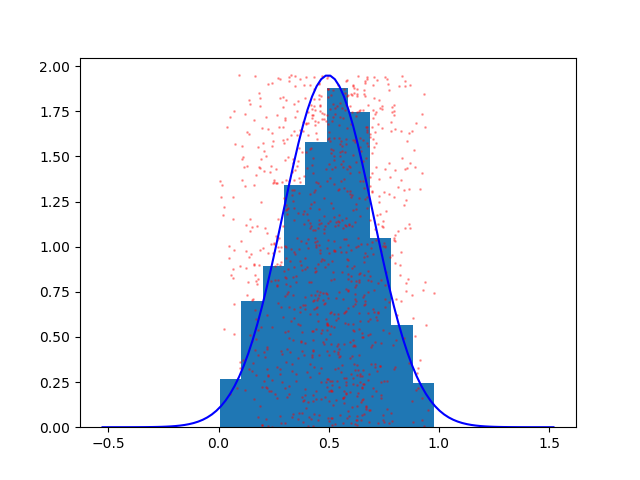

In [27]:
xmin,xmax,pmax=multiNormExt(fparams)
xt=np.linspace(xmin,xmax,100)
yt=multiNorm(xt,fparams)
y=np.random.uniform(0,pmax,Npoints)

fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'ro',ms=1,alpha=0.3)
ax.hist(x,normed=True)
ax.plot(xt,yt,'b-')

fig.savefig(f"{FIGDIR}/fit_multinorm.png")

In [28]:
def trapeziumPDF(x,params):
    a=params[0]
    b=params[1]
    c=params[2]
    m1=(a+b)/2-c/2
    m2=(a+b)/2+c/2
    if x<=a or x>=b:
        return 0
    Nint=((b-a)+c)/2
    if x<=m1:
        y=(x-a)/(m1-a)
    elif x<m2:
        y=1
    else:
        y=1-(x-m2)/(b-m2)
    return y/Nint

In [29]:
params=[0.0,1.0,0.3]
xmin,xmax,c=params
pmax=2/((xmax-xmin)+c)
print(pmax)

1.5384615384615383


<IPython.core.display.Javascript object>


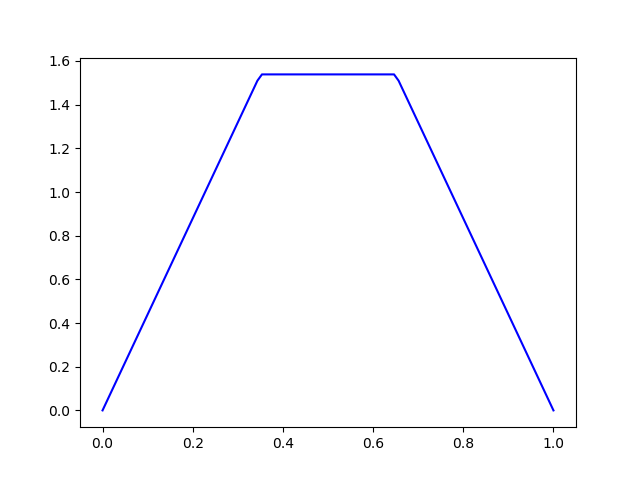

In [30]:
fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax,100)
ax.plot(xt,[trapeziumPDF(x,params) for x in xt],'b-')

fig.savefig(f"{FIGDIR}/plot_trapezium.png")

In [31]:
#integral(trianglePDF,xmin,xmax,args=(params,))
integral(trapeziumPDF,-np.inf,np.inf,args=(params,))

(0.9999999998657938, 1.2845073695937731e-08)

<IPython.core.display.Javascript object>


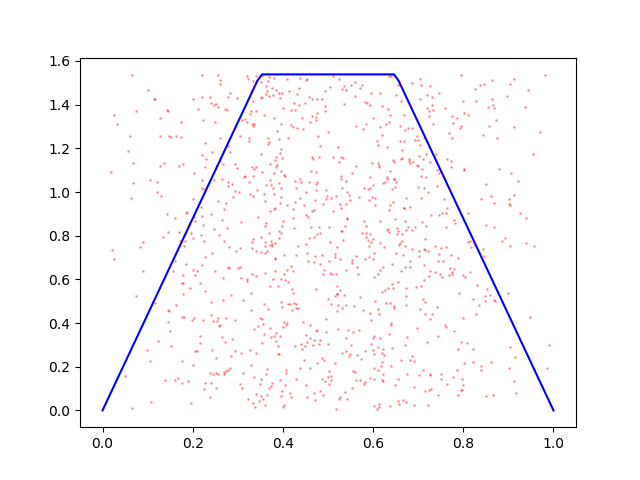

In [32]:
Npoints=1000
x=rejectionGenerate(Npoints,xmin,xmax,pmax,trianglePDF,params)
y=np.random.uniform(0,pmax,Npoints)

fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax,100)
ax.plot(xt,[trapeziumPDF(x,params) for x in xt],'b-')
ax.plot(x,y,'ro',ms=1,alpha=0.3)

fig.savefig(f"{FIGDIR}/random_trapezium.png")

In [33]:
N,gparams,bounds=multiNormParams(weights=[1.0,1.0],locs=[1.0,2.0],scales=[1.0,1.0])
margs=dict(method='SLSQP',bounds=bounds)
solution=minimize(Likelihood,gparams,args=(x,multiNorm),**margs)
solution

     fun: -56.87507998264795
     jac: array([9.53674316e-07, 4.27264528e+01, 2.51102448e-03, 0.00000000e+00,
       2.19893456e-02, 0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([9.86872815, 0.        , 0.49988304, 3.31491008, 0.21227071,
       1.23562995])

<IPython.core.display.Javascript object>


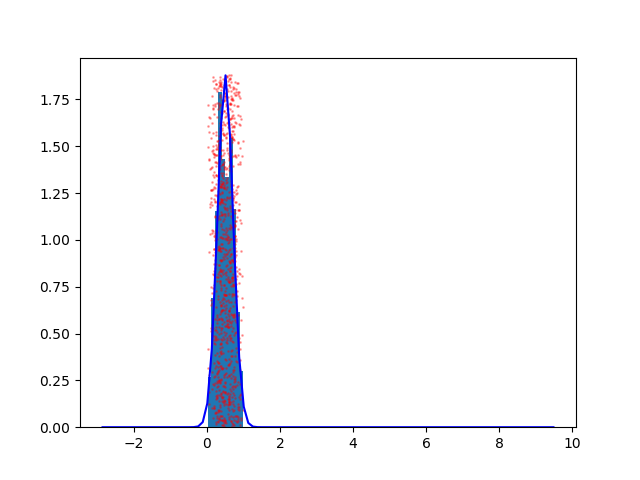

In [35]:
fparams=solution.x
xmin,xmax,pmax=multiNormExt(fparams)
xt=np.linspace(xmin,xmax,100)
yt=multiNorm(xt,fparams)
y=np.random.uniform(0,pmax,Npoints)

fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'ro',ms=1,alpha=0.3)
ax.hist(x,normed=True)
ax.plot(xt,yt,'b-')

fig.savefig(f"{FIGDIR}/fit_multinorm_trapezium.png")